In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%run -i harm_script.py

In [3]:
rg("gdump")

In [4]:
rd("dump000")

In [5]:
print(t)

0.0


Text(0, 0.5, 'rho')

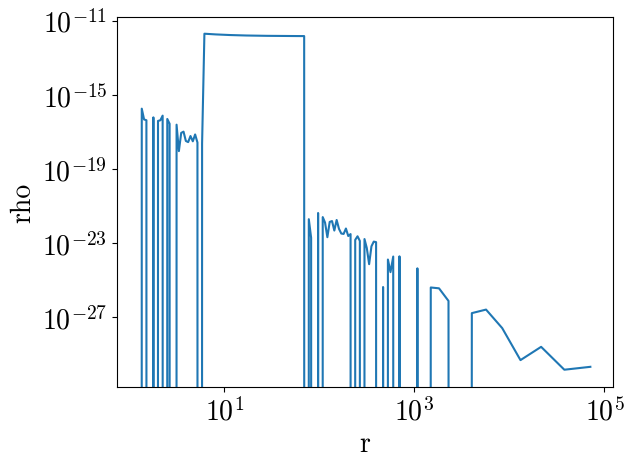

In [7]:
plt.loglog(r[:,ny//2,0], uu[3][:,ny//2,0])
plt.xlabel("r")
plt.ylabel("rho")

In [ ]:
plco(np.log10(rho),xy=1,xmax=100,ymax=50,cb=True, isfilled=1, nc=100)
# phi goes into the plane of the image

In [ ]:
!ls dumps

In [ ]:
import numpy as np
for i in np.arange(2):
    print(i)
    rd("dump%03d" % i)
    plco(np.log10(rho),xy=1,xmax=100,ymax=50,cb=True,isfilled=1,nc=100)
    plt.savefig("films/frame%03d.png" % i, dpi=300)

# for i in np.arange():
#     rd(f"dump00{i}")
#     plco(np.log10(rho),xy=1,xmax=100,ymax=50,cb=True, isfilled=1, nc=100)
#     plt.savefig(f"frame i")

In [ ]:
!ls *.png

In [ ]:
!ffmpeg -fflags +genpts -r 10 -pattern_type glob -i "frame*.png" -vcodec mpeg4 -qmax 5 movie.mp4

In [ ]:
# gcov: 
# rhor: event horizon radius
# phi, theta, 
# B is magnetic fields

# internal coordinates??? theta on y, log r on x
# plco(np.log10(rho),xy=0,cb=True,isfilled=1,nc=100)

# rho, ug, uu[1:4], B[1:4]
# rd means read dump

globals().keys()

In [15]:
# TODO we need a function that loops over all dumps in the file system
import os
import re
dumps = []
for filename in os.listdir('dumps'):
    if re.match(r'^dump\d+$', filename):
        dumps.append(filename)
dumps.sort()
num_dumps = len(dumps)
print(f'Number of Dumps: {num_dumps}')


Number of Dumps: 29


In [8]:
# TODO we need a function to translate a dump and the variables it reads into NN friendly tensors
import torch

# TODO make dataset
data = []
for dump in dumps:
    rd(dump)

    rho_tensor = torch.tensor(rho).squeeze(2).unsqueeze(0)
    ug_tensor = torch.tensor(ug).squeeze(2).unsqueeze(0)
    uu_tensor = torch.tensor(uu[1:4]).squeeze(3)
    B_tensor = torch.tensor(B[1:4]).squeeze(3)
    
    data_tensor = torch.cat((rho_tensor, ug_tensor, uu_tensor, B_tensor), dim=0)
    data.append(data_tensor.unsqueeze(0))

data = torch.cat(data, dim=0)
print(f'Shape of the dataset: {data.shape}')

Shape of the dataset: torch.Size([29, 8, 256, 256])


In [9]:
from torch.utils.data import Dataset, DataLoader, random_split
BATCH_SIZE = 8

class BHDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)-1

    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.dataset[idx+1]
        return data, label

loaded_data = BHDataset(data)
train_size = int(0.7 * len(loaded_data))
val_size = int(0.15 * len(loaded_data))
test_size = len(loaded_data) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(loaded_data, [train_size, val_size, test_size])

# TODO make dataloaders
# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
import torch.nn as nn
# TODO write the NN
class FFNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, input_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        x = self.relu(x)
        return x

In [ ]:
# TODO initialize net, loss, optim
net = FFNN(input_dim = 8*128*128)
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(params=net.parameters())

# TODO training script
losses = []
epochs = 2
for epoch in range(epochs):
    for batch_num, (batch, label) in enumerate(train_loader):
        # zero gradients
        optim.zero_grad()
        batch_len = len(batch)

        # 
        batch_reshaped = torch.reshape(batch, (batch_len,8*128*128))

        # make prediction
        pred = net.forward(batch_reshaped)
        pred_reshaped = torch.reshape(pred, (batch_len,8,128,128))

        # compute loss
        loss_value = loss_fn(pred_reshaped, label)
        losses.append(loss_value)

        loss_value.backward()

        optim.step()

        print(f"Loss value: {loss_value}")


In [ ]:
plt.plot([i for i in range(len(losses))], [loss.item() for loss in losses], label='Train Loss')
plt.title(f'Training and Validation Curve')
plt.xlabel(f'Number of Batches')
plt.ylabel(f'Loss (MSE)')
plt.legend()
plt.show()

Saved animated dumps at ./films/movie.gif


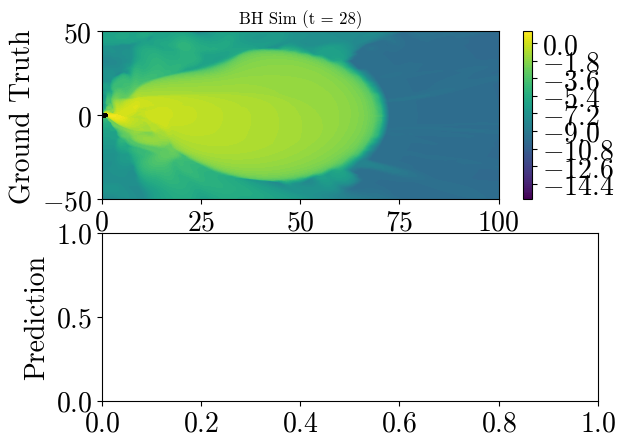

In [67]:
from anim import animate_dumps

animate_dumps(dumps = dumps, save_path = './films/movie.gif')
